In [1]:
DATASET_ROOT="./datasets/"
%pip install -r requirements.txt

import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import image_helper
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics.functional import structural_similarity_index_measure
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


Note: you may need to restart the kernel to use updated packages.


/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Modelos SRCNN diferentes

In [3]:
class SRCNN_f2_as_5(nn.Module):
    def __init__(self, num_channels=3, use_padding=True):
        super(SRCNN_f2_as_5, self).__init__()
        self.using_padding = use_padding
        padding = [0, 0, 0]
        if use_padding:
            padding = [9 // 2, 5 // 2, 5 // 2]
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=padding[0])
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=padding[1])
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=padding[2])
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


In [4]:
class SRCNN_f2_as_1(nn.Module):
    def __init__(self):
        super(SRCNN_f2_as_1, self).__init__()

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=9, padding=(2, 2)
        )
        self.conv2 = nn.Conv2d(
            64, 32, kernel_size=1, padding=(2, 2)
        )
        self.conv3 = nn.Conv2d(
            32, 3, kernel_size=5, padding=(2, 2)
        )

        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [9]:
# Carregando os modelos já treinados

In [12]:
model_f2_as_5 = SRCNN_f2_as_5().to(device)
model_f2_as_1 = SRCNN_f2_as_1().to(device)
try:
    model_f2_as_5.load_state_dict(torch.load('./srcnn__f2_as_5.pth'))
    model_f2_as_1.load_state_dict(torch.load('./srcnn_f2_as_1.pth'))
except:
    model_f2_as_5.load_state_dict(torch.load('./srcnn__f2_as_5.pth', map_location=torch.device('cpu')))
    model_f2_as_1.load_state_dict(torch.load('./srcnn_f2_as_1.pth', map_location=torch.device('cpu')))

In [13]:
# Imagem de exemplo

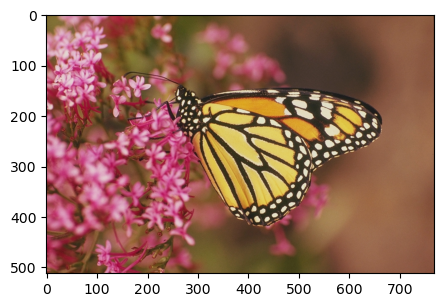

In [14]:
image = Image.open(f"{DATASET_ROOT}Set14/monarch.png")
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.show()

In [15]:
# Imagem de baixa resoulção

/var/folders/5z/jvmv1stj4531scvqz47n7cpc0000gn/T/ipykernel_85479/221402860.py:4: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.LINEAR),
/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


<Figure size 500x500 with 0 Axes>

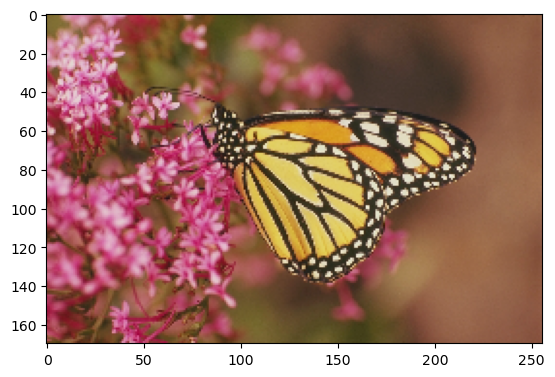

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.LINEAR),
])
low_res_image = transform(image)

plt.figure(figsize=(5, 5))
image_helper.show_tensor_as_image(low_res_image) 

In [17]:
# Upsampling com interpolação bicúbica

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 500x500 with 0 Axes>

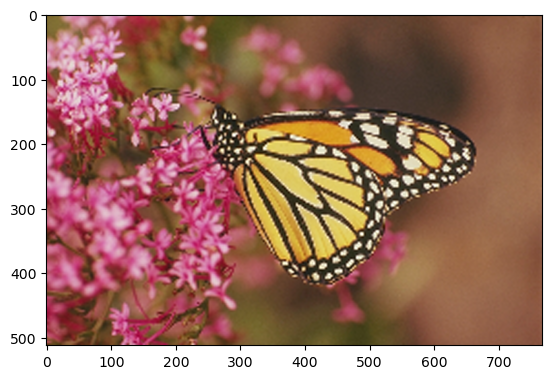

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.BICUBIC),
    # resize image to 256x256
    transforms.Resize((image.size[1], image.size[0]), interpolation=Image.BICUBIC)
])
bicubic_image = transform(image)

plt.figure(figsize=(5, 5))
image_helper.show_tensor_as_image(bicubic_image) 

In [19]:
# Imagem com o modelo SRCNN_f2_as_1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 500x500 with 0 Axes>

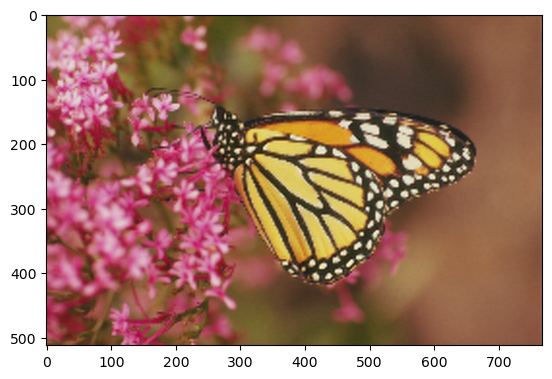

In [20]:
model_f2_as_1_image = model_f2_as_1(bicubic_image.to(device))
plt.figure(figsize=(5, 5))
image_helper.show_tensor_as_image(model_f2_as_1_image) 

In [21]:
# Imagem com o modelo SRCNN_f2_as_5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 500x500 with 0 Axes>

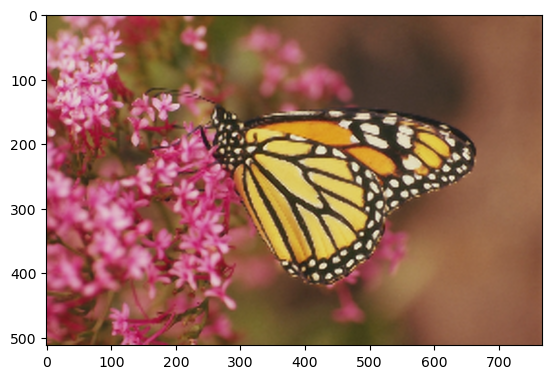

In [22]:
model_f2_as_5_image = model_f2_as_5(bicubic_image.to(device))
plt.figure(figsize=(5, 5))
image_helper.show_tensor_as_image(model_f2_as_5_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


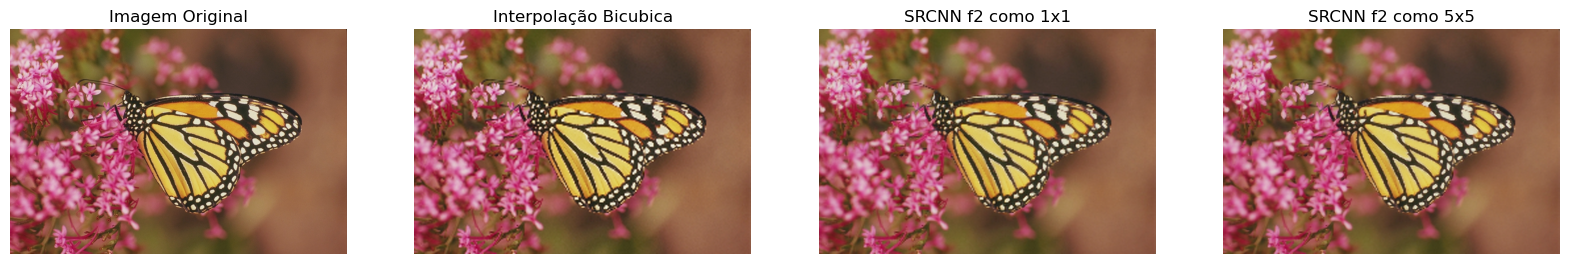

In [23]:
plt.figure(figsize=(20, 20))  # Adjust the width and height as per your preference


plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(bicubic_image.detach().numpy().transpose((1, 2, 0)))
plt.title("Interpolação Bicubica")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(model_f2_as_1_image.detach().numpy().transpose((1, 2, 0)))
plt.title("SRCNN f2 como 1x1")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(model_f2_as_5_image.detach().numpy().transpose((1, 2, 0)))
plt.title("SRCNN f2 como 5x5")
plt.axis('off')

plt.show()

In [24]:
# Calculando o PSNR

In [25]:
psnr = PeakSignalNoiseRatio()
model_f2_as_1_psnr_avg = 0
model_f2_as_5_psnr_avg = 0
bicubic_psnr_avg = 0
pathlist = Path(f"{DATASET_ROOT}Set14/").rglob('*.png')
img_count = 0
for path in tqdm(pathlist):
     img_count += 1

     # because path is object not string
     path_in_str = str(path)

     image = Image.open(path_in_str)

     transform = transforms.Compose([
          transforms.ToTensor(),
          # resize image to 33x33 and downsample by BICUBIC interpolation
          transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.BICUBIC),
          # resize image to 256x256
          transforms.Resize((image.size[1], image.size[0]), interpolation=Image.BICUBIC)
     ])
     bicubic_image = transform(image)
     
     model_image_f2_as_1 = model_f2_as_1(bicubic_image.to(device))
     model_image_f2_as_5 = model_f2_as_5(bicubic_image.to(device))

     # target for PSNR metric
     targets = transforms.ToTensor()(image)

     # bicubic PSNR
     preds = bicubic_image
     bicubic_psnr_avg += psnr(preds, targets)

     # model f2 as 1 PSNR
     preds = model_image_f2_as_1
     model_f2_as_1_psnr_avg += psnr(preds, targets)

     # model f2 as 5 PSNR
     preds = model_image_f2_as_5
     model_f2_as_5_psnr_avg += psnr(preds, targets)

bicubic_psnr_avg = bicubic_psnr_avg / img_count
model_f2_as_1_psnr_avg = model_f2_as_1_psnr_avg / img_count
model_f2_as_5_psnr_avg = model_f2_as_5_psnr_avg / img_count

print('bicubic_psnr_avg =', bicubic_psnr_avg)
print('model_f2_as_1_psnr_avg =', model_f2_as_1_psnr_avg)
print('model_f2_as_5_psnr_avg =', model_f2_as_5_psnr_avg)

0it [00:00, ?it/s]

14it [00:20,  1.49s/it]

bicubic_psnr_avg = tensor(24.4968)
model_f2_as_1_psnr_avg = tensor(24.6514, grad_fn=<DivBackward0>)
model_f2_as_5_psnr_avg = tensor(24.8940, grad_fn=<DivBackward0>)


In [26]:
psnr_df = pd.DataFrame({'Interpolação Bicúbica': [bicubic_psnr_avg.detach().numpy()],
                        'SRCNN f2 como 1x1': [model_f2_as_1_psnr_avg.detach().numpy()],
                        'SRCNN f2 como 5x5': [model_f2_as_5_psnr_avg.detach().numpy()]
                        , '': ['PSNR']})
psnr_df.set_index('' ,inplace=True)
psnr_df

,Interpolação Bicúbica,SRCNN f2 como 1x1,SRCNN f2 como 5x5
,,,
PSNR,24.496826,24.651415,24.893967


In [28]:
df_model_f2_as_1 = pd.read_csv('./srcnn_f2_as_1.csv')
df_model_f2_as_5 = pd.read_csv('./srcnn_f2_as_5.csv')

In [29]:
# Ajeitando os dados entre os df's
# pegar primeiras 150 linhas do df_model_f2_as_1
df_model_f2_as_1 = df_model_f2_as_1.head(150)

In [30]:
time_per_epoch_f2_as_1 = df_model_f2_as_1['epoch_duration [s]'].sum() / df_model_f2_as_1.shape[0]
time_per_epoch_f2_as_5 = df_model_f2_as_5['epoch_duration [s]'].sum() / df_model_f2_as_5.shape[0]
df_time_per_epoch_avg = pd.DataFrame({'SRCNN f2 como 1x1': [time_per_epoch_f2_as_1],
                                        'SRCNN f2 como 5x5': [time_per_epoch_f2_as_5]
                                        , '': ['Tempo por época']})
df_time_per_epoch_avg.set_index('' ,inplace=True)
df_time_per_epoch_avg

,SRCNN f2 como 1x1,SRCNN f2 como 5x5
,,
Tempo por época,299.023298,365.859918


In [31]:
# Observamos que o modelo SRCNN f2 como 5x5 tem um PSNR maior que o modelo SRCNN f2 como 1x1
# Porém, o modelo SRCNN f2 como 5x5 tem um tempo de treinamento maior que o modelo SRCNN f2 como 1x1, o que pode ser um fator decisivo para a escolha do modelo.